In [1]:
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Cargar Datos

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data_ori = pd.read_csv("/kaggle/input/titanic/test.csv")

In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Explorar Datos

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


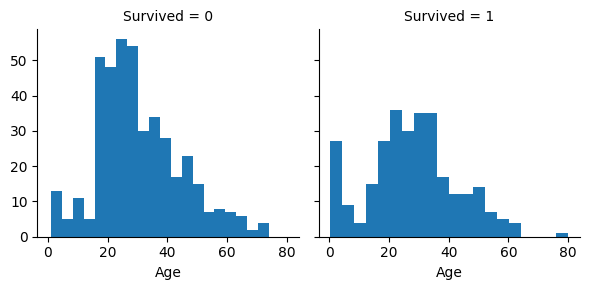

In [9]:
import seaborn as sns

g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [10]:
x = train_data.copy()

In [11]:
x.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
df_enc = pd.get_dummies(x, columns=["Sex", "Embarked"])
df_enc.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,True,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,False,True,False,False,True


In [13]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Sex_female   891 non-null    bool   
 11  Sex_male     891 non-null    bool   
 12  Embarked_C   891 non-null    bool   
 13  Embarked_Q   891 non-null    bool   
 14  Embarked_S   891 non-null    bool   
dtypes: bool(5), float64(2), int64(5), object(3)
memory usage: 74.1+ KB


In [14]:
print(df_enc[df_enc.isnull().any(axis=1)])

     PassengerId  Survived  Pclass                                      Name  \
0              1         0       3                   Braund, Mr. Owen Harris   
2              3         1       3                    Heikkinen, Miss. Laina   
4              5         0       3                  Allen, Mr. William Henry   
5              6         0       3                          Moran, Mr. James   
7              8         0       3            Palsson, Master. Gosta Leonard   
..           ...       ...     ...                                       ...   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
886          887         0       2                     Montvila, Rev. Juozas   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
890          891         0       3                       Dooley, Mr. Patrick   

      Age  SibSp  Parch            Tick

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


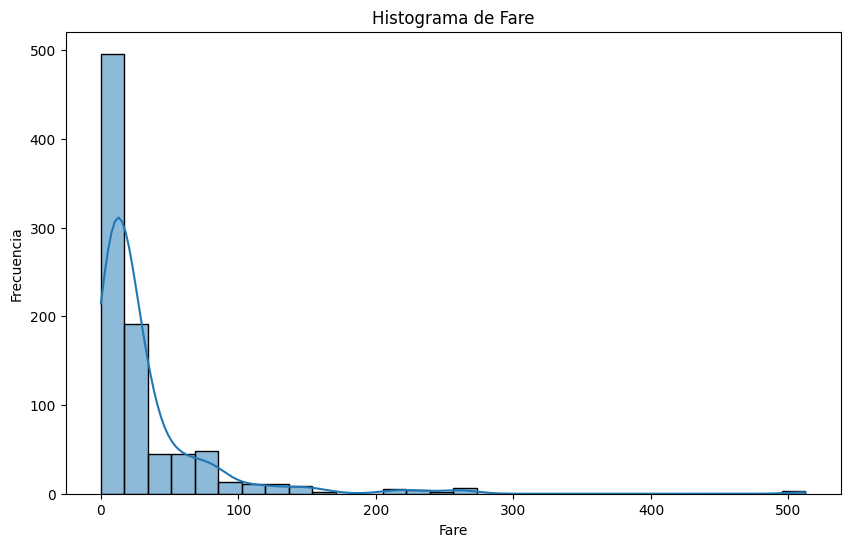

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Fare'], kde=True, bins=30)
plt.title('Histograma de Fare')
plt.xlabel('Fare')
plt.ylabel('Frecuencia')
plt.show()

In [16]:
bins = list(range(0, int(train_data['Fare'].max()) + 50, 50))

# Dividir la variable Fare en grupos
aux = train_data
print(pd.cut(train_data['Fare'], bins=bins).value_counts().sort_index())

Fare
(0, 50]       716
(50, 100]     107
(100, 150]     24
(150, 200]      9
(200, 250]     11
(250, 300]      6
(300, 350]      0
(350, 400]      0
(400, 450]      0
(450, 500]      0
(500, 550]      3
Name: count, dtype: int64


In [17]:
print(train_data['Cabin'].value_counts())

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64


# Modelo 0 (punto de partida)

Generamos un primer modelo sencillo de un RF con algunas variables para ver una estimación del accuracy y tener un punto de partida

In [18]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X_train, X_test, y_train, y_test = train_test_split(train_data[features], y, test_size=0.2, random_state=42, stratify=y)

In [19]:
X_train = pd.get_dummies(X_train[features])
X_test = pd.get_dummies(X_test[features])

In [20]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, predictions)

In [22]:
print("Accuracy base: ", accuracy)

Accuracy base:  0.770949720670391


In [23]:
# output = pd.DataFrame({'PassengerId': test_data_ori.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# Preprocesamiento de los datos

A continuación se trabajarán una serie de técnicas para intentar mejorar el conjunto de datos

In [24]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Eliminación de variables

Delete variables PasssengerID, Name y Ticket because they don't give us relevant information

In [25]:
train_data_del = train_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
train_data_del.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Discretización de las variables

We're going to split the Age variable in some strip

In [26]:
# Definir los límites de los grupos
age_bins = [0, 15, 30, 60, 150]

# Definir los números para los grupos
age_labels = [0, 1, 2, 3]

# Dividir la columna Age en grupos y asignar los números
train_data_disc = train_data_del
train_data_disc['Strip_Age'] = pd.cut(train_data_disc['Age'], bins=age_bins, labels=age_labels, right=False)
train_data_disc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Strip_Age
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,2


Ahora vamos a hacer lo mismo con la columna Fare

In [27]:
# Definir los límites de los grupos
fare_bins = [0, 30, 60, 100, 150, 250, 1000]

# Definir los números para los grupos
fare_labels = [0, 1, 2, 3, 4, 5]

# Dividir la columna Age en grupos y asignar los números
train_data_disc['Strip_Fare'] = pd.cut(train_data_disc['Fare'], bins=fare_bins, labels=fare_labels, right=False)
train_data_disc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Strip_Age,Strip_Fare
0,0,3,male,22.0,1,0,7.2500,S,1,0
1,1,1,female,38.0,1,0,71.2833,C,2,2
2,1,3,female,26.0,0,0,7.9250,S,1,0
3,1,1,female,35.0,1,0,53.1000,S,2,1
4,0,3,male,35.0,0,0,8.0500,S,2,0


Eliminamos las columnas continuas entonces

In [28]:
train_data_disc = train_data_disc.drop(["Age", "Fare"], axis = 1)
train_data_disc.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Strip_Age,Strip_Fare
0,0,3,male,1,0,S,1,0
1,1,1,female,1,0,C,2,2
2,1,3,female,0,0,S,1,0
3,1,1,female,1,0,S,2,1
4,0,3,male,0,0,S,2,0


### Convert to numerical 

In [29]:
train_data_num = train_data_disc
train_data_num['IsMale'] = np.where(train_data_num['Sex'] == "male", 1, 0)
train_data_num = pd.get_dummies(train_data_disc, columns=["Embarked"])
train_data_num = train_data_num.drop(["Sex"], axis = 1)
train_data_num.head()

,Survived,Pclass,SibSp,Parch,Strip_Age,Strip_Fare,IsMale,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,0,1,0,1,False,False,True
1,1,1,1,0,2,2,0,True,False,False
2,1,3,0,0,1,0,0,False,False,True
3,1,1,1,0,2,1,0,False,False,True
4,0,3,0,0,2,0,1,False,False,True


### Creation of new Variables

Create new variables:
* Familysize: Sum the column SibSp and Parch
* IsAlone: Show if the traveller is alone or not

In [30]:
train_data_new = train_data_num
train_data_new["FamilySize"] = train_data_new["SibSp"] + train_data_new["Parch"]
train_data_new['IsAlone'] = np.where(train_data_new['FamilySize'] == 0, 1, 0)
train_data_new.head()

,Survived,Pclass,SibSp,Parch,Strip_Age,Strip_Fare,IsMale,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0,3,1,0,1,0,1,False,False,True,1,0
1,1,1,1,0,2,2,0,True,False,False,1,0
2,1,3,0,0,1,0,0,False,False,True,0,1
3,1,1,1,0,2,1,0,False,False,True,1,0
4,0,3,0,0,2,0,1,False,False,True,0,1


Delete the previous columns

In [31]:
train_data_new = train_data_new.drop(["SibSp", "Parch"], axis = 1)
train_data_new.head()

,Survived,Pclass,Strip_Age,Strip_Fare,IsMale,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0,3,1,0,1,False,False,True,1,0
1,1,1,2,2,0,True,False,False,1,0
2,1,3,1,0,0,False,False,True,0,1
3,1,1,2,1,0,False,False,True,1,0
4,0,3,2,0,1,False,False,True,0,1


### Check and Fill NaN Values

In [32]:
print(train_data_new.columns[train_data_new.isnull().any()])

Index(['Strip_Age'], dtype='object')


Impute the NaN values fot Strip_Age column using KNNImputer

In [33]:
imputer = KNNImputer(n_neighbors=5)
train_data_new_imputed = pd.DataFrame(imputer.fit_transform(train_data_new), columns=train_data_new.columns)

In [34]:
train_data_new_imputed.head()

,Survived,Pclass,Strip_Age,Strip_Fare,IsMale,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Volvemos a comprobar y vemos que no hay ningún valor vacío

In [35]:
print(train_data_new_imputed.columns[train_data_new_imputed.isnull().any()])

Index([], dtype='object')


### Show correlation matrix

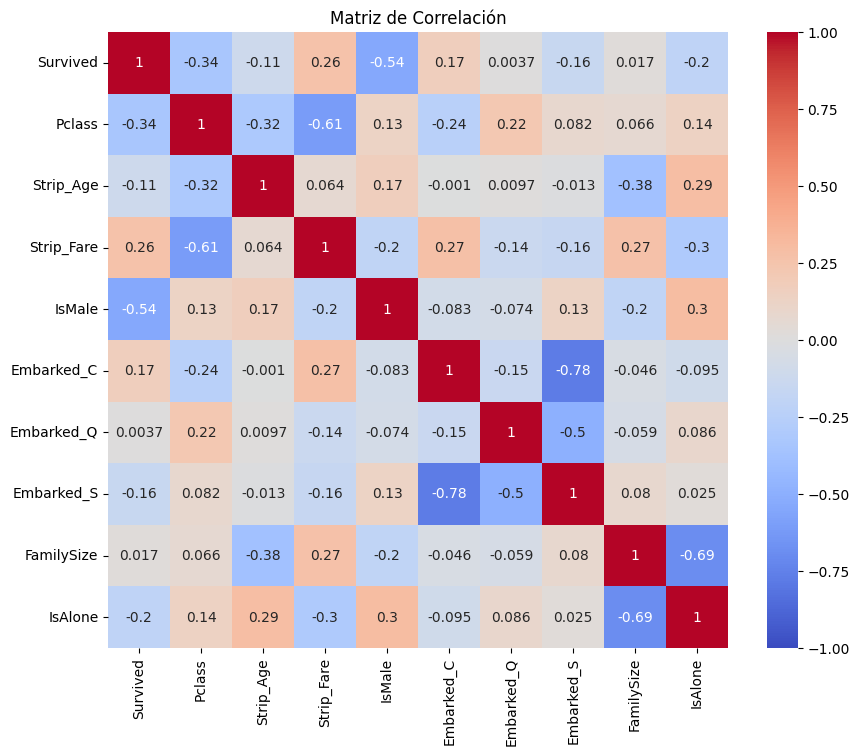

In [36]:
correlation_matrix = train_data_new_imputed.corr()
# Visualizar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

## Do all the previous process to the test

In [37]:
test_data = test_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
test_data['Strip_Age'] = pd.cut(test_data['Age'], bins=age_bins, labels=age_labels, right=False)
test_data['Strip_Fare'] = pd.cut(test_data['Fare'], bins=fare_bins, labels=fare_labels, right=False)
test_data = test_data.drop(["Age", "Fare"], axis = 1)
test_data['IsMale'] = np.where(test_data['Sex'] == "male", 1, 0)
test_data = pd.get_dummies(test_data, columns=["Embarked"])
test_data = test_data.drop(["Sex"], axis = 1)
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"]
test_data['IsAlone'] = np.where(test_data['FamilySize'] == 0, 1, 0)
test_data = test_data.drop(["SibSp", "Parch"], axis = 1)

Comprobamos si hay algún valor nulo

In [38]:
print(test_data.columns[test_data.isnull().any()])

Index(['Strip_Age', 'Strip_Fare'], dtype='object')


Imputamos valores

In [39]:
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)

Volvemos a comprobar que no haya valores vacíos

In [40]:
print(test_data.columns[test_data.isnull().any()])

Index([], dtype='object')


#  MODELOS

## Modelo 0 Con Datos Preprocesados

Ejecutamos el mismo modelo que la primera vez para ver si se ha mejorado algo

División de los datos

In [41]:
# División de datos en conjuntos de entrenamiento y prueba
X = train_data_new_imputed.drop('Survived', axis=1)  # Suponiendo que no hay columnas con NaN
y = train_data_new_imputed['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Creación del modelo

In [42]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

In [43]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

In [44]:
print("Accuracy: ", accuracy)

Accuracy:  0.8044692737430168


Hemos mejorado algo. Así que vamos a explorar nuevos modelos e intentar ajustarlos

### Modelo 1

In [45]:
# Definición del modelo Random Forest
model = RandomForestClassifier()

In [46]:
# Búsqueda de hiperparámetros con validación cruzada (GridSearchCV)
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [7, 10, 15],
    'min_samples_split': [5, 10, 15]
}

grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=5)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy')

In [47]:
# Obtención de los hiperparámetros óptimos
results = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_
# Mostrar los resultados
print("Mejores parámetros encontrados:")
print(best_params)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Mejores parámetros encontrados:
{'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 150}
Mejor puntuación de validación cruzada: 0.8315177779966512


Analisis de todos los hiperparámetros

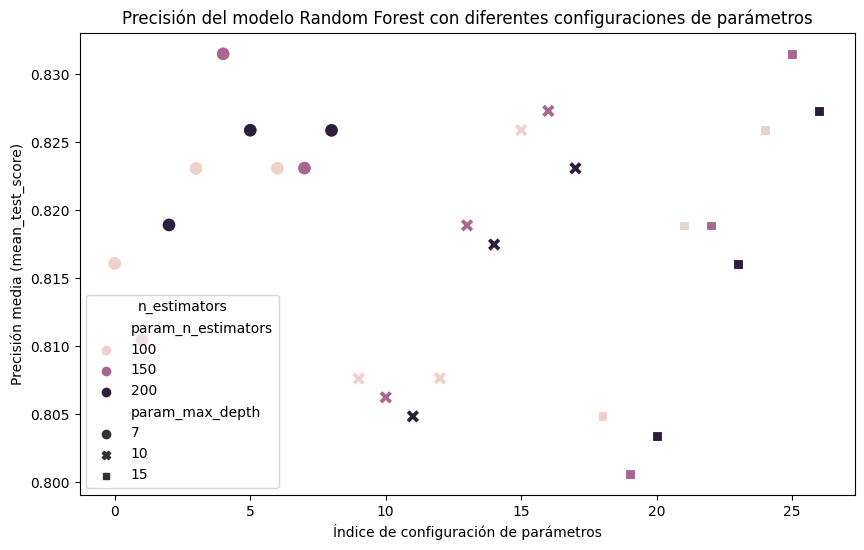

In [48]:
# Dibujar la gráfica con los parámetros y su precisión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x=results.index, y='mean_test_score', hue='param_n_estimators', style='param_max_depth', s=100)

plt.xlabel('Índice de configuración de parámetros')
plt.ylabel('Precisión media (mean_test_score)')
plt.title('Precisión del modelo Random Forest con diferentes configuraciones de parámetros')
plt.legend(title='n_estimators')
plt.show()

In [49]:
# Entrenamiento del modelo con los hiperparámetros óptimos
model.set_params(n_estimators = 200, max_depth = 7, min_samples_split = 10)  # Ejemplo de hiperparámetros óptimos
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=10, n_estimators=200)

In [50]:
# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy en el conjunto de prueba:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("Puntaje F1:", f1)

Accuracy en el conjunto de prueba: 0.8324022346368715
Precisión: 0.8679245283018868
Sensibilidad: 0.6666666666666666
Puntaje F1: 0.7540983606557377


Otros análisis

# Modelo 2

Usamos otra cosa que no sea RF

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [52]:
param_grid2 = {
    'n_neighbors': [2, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [53]:
# Crear el modelo KNN
knn = KNeighborsClassifier()

# Configurar el GridSearchCV
grid_search2 = GridSearchCV(estimator=knn, param_grid=param_grid2, cv=5, n_jobs=-1, verbose=2)


In [54]:
# Entrenar el modelo
grid_search2.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [55]:
# Obtener los mejores hiperparámetros
print(f'Mejores hiperparámetros: {grid_search2.best_params_}', "Accuracy: ", grid_search2.best_score_)

# Realizar predicciones con el mejor modelo
best_knn = grid_search2.best_estimator_
y_pred2 = best_knn.predict(X_test)

Mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'} Accuracy:  0.7964247020585049


In [56]:
# Calcular la precisión del modelo
accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Precisión del modelo: {accuracy2:.2f}')

Precisión del modelo: 0.75


In [57]:
# Mostrar el reporte de clasificación
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred2))

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79       110
         1.0       0.67      0.68      0.68        69

    accuracy                           0.75       179
   macro avg       0.73      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



In [58]:
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)

print("Accuracy en el conjunto de prueba:", accuracy2)
print("Precisión:", precision2)
print("Sensibilidad:", recall2)
print("Puntaje F1:", f12)

Accuracy en el conjunto de prueba: 0.7486033519553073
Precisión: 0.6714285714285714
Sensibilidad: 0.6811594202898551
Puntaje F1: 0.6762589928057554


# Modelo 3

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
param_grid3 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
    'base_estimator__max_depth': [1, 2, 3, 4, 5]
}

In [61]:
# Crear el modelo base
estimator = DecisionTreeClassifier()

# Crear el modelo AdaBoost
ada = AdaBoostClassifier(estimator=estimator)

# Configurar el GridSearchCV
grid_search3 = GridSearchCV(estimator=ada, param_grid=param_grid3, cv=5, n_jobs=-1, verbose=2)

# Entrenar el modelo
grid_search3.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
print(f'Mejores hiperparámetros: {grid_search3.best_params_}')


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan,

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan,

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

Mejores hiperparámetros: {'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}


In [62]:
# Obtener los mejores hiperparámetros
print(f'Mejores hiperparámetros: {grid_search3.best_params_}')
print("Accuracy: ", grid_search3.best_score_)

Mejores hiperparámetros: {'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}
Accuracy:  0.8300994779868021


In [63]:
best_ADA = grid_search3.best_estimator_
y_pred3 = best_ADA.predict(X_test)

In [64]:
accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3)
recall3 = recall_score(y_test, y_pred3)
f13 = f1_score(y_test, y_pred3)

print("Accuracy en el conjunto de prueba:", accuracy3)
print("Precisión:", precision3)
print("Sensibilidad:", recall3)
print("Puntaje F1:", f13)

Accuracy en el conjunto de prueba: 0.8435754189944135
Precisión: 0.847457627118644
Sensibilidad: 0.7246376811594203
Puntaje F1: 0.7812499999999999


# Modelo 4

In [65]:
from xgboost import XGBClassifier
param_grid4 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.3]
}

# Inicializar XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), seed=42)

# Inicializar GridSearchCV
grid_search4 = GridSearchCV(estimator=xgb_model, param_grid=param_grid4, scoring='accuracy', cv=5, verbose=0)

# Ajustar GridSearchCV
grid_search4.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=2,
                                     num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [66]:
# Mostrar los resultados
print("Mejores parámetros encontrados:")
print(grid_search4.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search4.best_score_)

Mejores parámetros encontrados:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mejor puntuación de validación cruzada: 0.8451133011110412


In [67]:
best_XGBoost = grid_search4.best_estimator_
y_pred4 = best_XGBoost.predict(X_test)

In [68]:
accuracy4 = accuracy_score(y_test, y_pred4)
precision4 = precision_score(y_test, y_pred4)
recall4 = recall_score(y_test, y_pred4)
f14 = f1_score(y_test, y_pred4)

print("Accuracy en el conjunto de prueba:", accuracy4)
print("Precisión:", precision4)
print("Sensibilidad:", recall4)
print("Puntaje F1:", f14)

Accuracy en el conjunto de prueba: 0.8547486033519553
Precisión: 0.8771929824561403
Sensibilidad: 0.7246376811594203
Puntaje F1: 0.7936507936507936


# Create submition

In [69]:
test_data.head()

,Pclass,Strip_Age,Strip_Fare,IsMale,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,3.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,3.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0


In [70]:
predictions = best_XGBoost.predict(test_data)

In [71]:
output = pd.DataFrame({'PassengerId': test_data_ori.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [72]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
